Run the following cell to load the package you are going to use. 

In [2]:
!pip install nltk
!pip install wordcloud

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 163kB 3.5MB/s ta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import pandas as pd
import nltk
import re
import string
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline



## IMDB dataset

IMDB dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. 

The dataset can be dowloaded from http://ai.stanford.edu/~amaas/data/sentiment/

The dataset is introduced in this paper https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf

Let's first load the IMDB dataset from df_IMDb.csv file. Note that the dataset is already converted from the orginal source format. 

Using the head() method we print the first 5 rows of the dataframe.

In [5]:
df_reviews = pd.read_csv('data/small_df_IMDb.csv')
df_reviews.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [6]:
print("There are {} observations and {} classes in this dataset. \n".format(df_reviews.shape[0],df_reviews.shape[1]))

There are 10000 observations and 2 classes in this dataset. 



Let's look closer to one of these reviews:

In [7]:
df_reviews.loc[12]['review']

"Bela Lugosi as creepy insane scientist who uses orchids to woo brides in order to steal life essence for aged wife. The midget in this film is hilarious!! A lot of freaks, plus a lot of padding and no plot makes watching this film a nightmare. I loved how all the pieces fell together in the end in typical Hollywood fashion. The story never gets interesting, and you feel helpless as you watch.<br /><br />Usually I'd score bore flicks like this one low, but the midget added just enough creepiness and entertainent to gain a couple more points."

### Deeper into IMBD dataset

WordCloud (https://amueller.github.io/word_cloud/index.html) is a technique to show which words are the most frequent among the given text. 

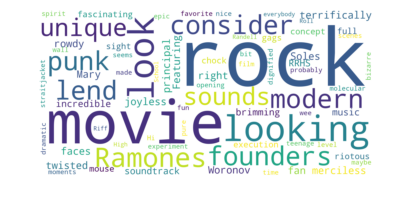

In [8]:
text = df_reviews.loc[100]['review']

#  Create stopword list
my_stopwords = set(STOPWORDS)
my_stopwords.update(["br"])

# generate and save the word cloud image to a file
wc = WordCloud(scale=5, 
               background_color="white", 
               max_words=100, 
               stopwords=my_stopwords)

wc.generate(text)
wc.to_file("WordCloud.png")

# show the wordcloud as output
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


## Data Preprocessing

In this section we will define a function that takes a text string as a parameter and then performs preprocessing on the string to remove special characters and HTML tags from the string.

In [9]:
#Numbers removing

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

def remove_numbers(input_text):
    return re.sub(r'\d+', '', input_text)

def remove_punctuation(input_text):
    return ''.join(c for c in input_text if c not in punctuation)

def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()


In [10]:
text = """
this text.   should be cleaned. 
there are mainly 3 steps, (1) remove      numbers, (2) remove punctuation (3) remove tags like <b>.
We also need to remove symbols like &^@....'
"""  

# text = df_reviews.loc[150]['review']

print('----- Original text', text)

----- Original text 
this text.   should be cleaned. 
there are mainly 3 steps, (1) remove      numbers, (2) remove punctuation (3) remove tags like <b>.
We also need to remove symbols like &^@....'



In [11]:
print('\n*** Remove tags')
text = remove_tags(text)
print(text)

print('\n*** Remove numbers')
text = remove_numbers(text)
print(text)

print('\n*** Remove puctuation')
text = remove_punctuation(text)
print(text)

print('\n*** Remove multiple spaces')
text = remove_multiple_spaces(text)
print(text)


*** Remove tags

this text.   should be cleaned. 
there are mainly 3 steps, (1) remove      numbers, (2) remove punctuation (3) remove tags like .
We also need to remove symbols like &^@....'


*** Remove numbers

this text.   should be cleaned. 
there are mainly  steps, () remove      numbers, () remove punctuation () remove tags like .
We also need to remove symbols like &^@....'


*** Remove puctuation

this text   should be cleaned 
there are mainly  steps  remove      numbers  remove punctuation  remove tags like 
We also need to remove symbols like 


*** Remove multiple spaces
this text should be cleaned there are mainly steps remove numbers remove punctuation remove tags like We also need to remove symbols like


### Stop words removal and Tokenization

<b>“Stop words”</b> are the most common words in a language like “the”, “a”, “on”, “is”, “all”. These words do not carry important meaning and are usually removed from texts. It is possible to remove stop words using Natural Language Toolkit (NLTK), a suite of libraries and programs for symbolic and statistical natural language processing.

<b>Tokenization</b> is the process of taking a text or set of texts and breaking it up into its individual words. In this step, we will tokenize text with the help of splitting text by space or punctuation marks.

In [15]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
nltk.download('punkt')

def tokenize(text):
    stop_words = ENGLISH_STOP_WORDS
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop_words]
    return (result)

[nltk_data] Downloading package punkt to /Users/couali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
tokenize(text)

['text',
 'cleaned',
 'mainly',
 'steps',
 'remove',
 'numbers',
 'remove',
 'punctuation',
 'remove',
 'tags',
 'like',
 'We',
 'need',
 'remove',
 'symbols',
 'like']

### Stemming

Stemming is the process of reducing inflected words to their word stem. For example, "listen", "listened", "listening" are reduced to the same stem "listen". Some application like sentiment analysis can benefit from stemming because it reduces vocabulary and increase the relevance of the concept.

For stemming, we can use SnowballStemmer in nltk.stem.snowball:

In [17]:
from nltk.stem.snowball import SnowballStemmer
st = SnowballStemmer('english')

print('running -->',st.stem('running'))
print('greatly -->', st.stem('greatly'))

running --> run
greatly --> great


### Lemmatization

Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. For example, "am", "are", "is" are lemmatized to the same form "be".

For stemming, we can use WordNetLemmatizer in nltk.stem.wordnet. Before we use the lemmatizer, we should download WordNet:

In [18]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize('am', pos='v'))
print(lemmatizer.lemmatize("cacti"))
print(lemmatizer.lemmatize("geese"))
print(lemmatizer.lemmatize("rocks"))
print(lemmatizer.lemmatize("python"))
print(lemmatizer.lemmatize("better", pos="a"))
print(lemmatizer.lemmatize("best", pos="a"))

[nltk_data] Downloading package wordnet to /Users/couali/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
be
cactus
goose
rock
python
good
best
